In [ ]:
pip install simpleitk --user
pip install Keras-Applications --user
pip install seaborn --user
pip install --upgrade numpy==1.19.2 --user
pip install -U tensorflow_probability==0.12.2 --user

In [ ]:
import numpy
from keras import * 
from keras.layers import *
import math
import keras
import numpy as np
import glob
import tensorflow as tf
import datetime, os
import seaborn as sns
import SimpleITK as sitk
from sklearn.metrics import confusion_matrix, roc_curve
from sklearn.model_selection import train_test_split
import tensorflow.keras.backend as K
from PIL import Image
import matplotlib.pyplot as plt
from keras.applications.vgg16 import VGG16
import keras.backend as K
from keras.models import Model
import tensorflow as tf
from tensorflow import keras
from tensorflow.python.keras import backend as K
from tensorflow.python.ops import array_ops
from tensorflow.python.ops import math_ops
import tensorflow_probability as tfp
tf.compat.v1.enable_eager_execution()

In [ ]:
checkpoint_path = "project_02/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,save_weights_only=True,verbose=1)

# Set model for perceptual loss, using VGG16
vgg16 = VGG16(include_top=False, weights='imagenet', input_shape=(256,256,3))
vgg16.trainable = False
for l in vgg16.layers:
    l.trainable = False

def custom_loss(y_true,y_pred):
    alpha = 0.01
    y_true = tf.convert_to_tensor(tf.cast(y_true,dtype=tf.float32))
    y_pred = tf.convert_to_tensor(tf.cast(y_pred,dtype=tf.float32))
    true = tf.reshape(K.concatenate([y_true,y_true,y_true]),(-1,256,256,3))
    pred = tf.reshape(K.concatenate([y_pred,y_pred,y_pred]),(-1,256,256,3))
    VGGloss = K.mean(K.square(vgg16(pred)-vgg16(true)))
    NPCCloss = npcc_loss(y_pred,y_true)
    NPCCloss = tf.cast(NPCCloss, tf.float32)
    loss = alpha*VGGloss + NPCCloss
    return loss

def npcc_loss(x,y):
    x = tf.convert_to_tensor(tf.cast(x,dtype=tf.float32))
    y = tf.convert_to_tensor(tf.cast(y,dtype=tf.float32))
    return 1-tfp.stats.correlation(x,y, sample_axis=None, event_axis=None)

#Create a father class to set some basic setting
class Net(object):
    # successor need to overwrite the __init__ function
    def __init__(self, learning_rate: np.float64=1e-4):
        self.epoch_history = None
        self.batch_history = None
        self.learning_rate = learning_rate
        self.model = tf.keras.Sequential()
        # input layer
    
    # check model parameters
    def model_summary(self):
        return self.model.summary()
    
    # train the model
    def train_model(self, train_data: tuple, val_data: tuple, batch_size: int=32, epochs: int=50):
        self.batch_history = LossHistory()
        print('=================training model=================================================')
        self.epoch_history = self.model.fit(x=train_data[0], y=train_data[1],
                                            epochs=epochs, 
                                              validation_data=val_data, 
                                              batch_size=batch_size,
                                              callbacks=[cp_callback])
                                              
    
    def predict(self, input):
        prediction = self.model.predict(input)
        return prediction
    def visualize_performance(self, title: str, interval: int=50, figsize: tuple=(16, 12)):
            history = self.batch_history.history
            x_label = 'batch'
            
            x_tick = np.arange(0, len(history['loss']), interval)
          
            loss = [history['loss'][i] for i in x_tick]

            accuracy = [history['accuracy'][i] for i in x_tick]
            print(accuracy)      
            # x axis ticks 
            xlabel_train = [i + 1 for i in x_tick]
            xlabel_val = [i + 1 for i in range(len(history['val_loss']))]
                
            plt.figure(figsize=figsize)

            plt.subplot(2, 2, 1)        
            plt.xlabel(x_label)
            plt.ylabel('loss')
            plt.plot(xlabel_train, loss, color='red', label='loss')
            plt.legend()
            plt.title('training data loss')
            # add grid
            plt.grid(b=True, which='major', color='red', linestyle='-')
            plt.minorticks_on()
            plt.grid(b=True, which='minor', color='black', linestyle='-', alpha=0.2)

            plt.subplot(2, 2, 2)
            plt.xlabel(x_label)
            plt.ylabel('accuracy')
            plt.plot(xlabel_train, accuracy, color='black', label='accuracy')
            plt.legend()
            plt.title('training data accuracy (threshold = 0.5)')
            plt.grid(b=True, which='major', color='red', linestyle='-')
            plt.minorticks_on()
            plt.grid(b=True, which='minor', color='black', linestyle='-', alpha=0.2)
            
            
            plt.subplot(2, 2, 3)
            plt.xlabel('epoch')
            plt.ylabel('val_Loss')
            plt.plot(xlabel_val, history['val_loss'], color='red', label='val_loss')
            plt.legend()
            plt.title('validate data loss')
            plt.grid(b=True, which='major', color='red', linestyle='-')
            plt.minorticks_on()
            plt.grid(b=True, which='minor', color='black', linestyle='-', alpha=0.2)
            
            plt.subplot(2, 2, 4)
            plt.xlabel('epoch')
            plt.ylabel('val_accuracy')
            plt.plot(xlabel_val, history['val_accuracy'], color='black', label='val_accuracy')
            plt.legend()
            plt.title('validate data accuracy (threshold = 0.5)')
            plt.grid(b=True, which='major', color='red', linestyle='-')
            plt.minorticks_on()
            plt.grid(b=True, which='minor', color='black', linestyle='-', alpha=0.2)
            
            plt.suptitle(title)
            plt.show()

class LossHistory(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.history = {'loss': [], 'accuracy': [], 'val_loss': [], 'val_accuracy': []}
    
    # record loss and accuracy after each batch
    def on_batch_end(self, batch, logs={}):
        self.history['loss'].append(logs.get('loss'))
        self.history['accuracy'].append(logs.get('accuracy'))
    
    # record val_loss and val_accuracy after each epoch
    def on_epoch_end(self, epoch, logs={}):
        self.history['val_loss'].append(logs.get('val_loss'))
        self.history['val_accuracy'].append(logs.get('val_accuracy'))

class addLayer(tf.keras.layers.Layer):
    def __init__(self, input_shape=(256,256,1)):    
        super(addLayer, self).__init__()
        wavelength = 180e-6
        z = 80
        dp = 0.00374
        Lx = dp*256
        Ly = dp*256
        x = np.linspace(-Lx/2,Lx/2,256)
        y = np.linspace(-Ly/2,Ly/2,256)
        xx, yy = np.meshgrid(x, y, sparse=True)
        P = np.pi*(xx**2+yy**2)/(wavelength*z)
        P = np.remainder(P,2*math.pi)-math.pi
        self.P = P.reshape(256,256,1)
    def call(self, inputs):
        return inputs+self.P

def rescale_layer(new_input):
    normalized = (new_input - tf.reduce_min(new_input))/(tf.reduce_max(new_input) - tf.reduce_min(new_input))
    return normalized

class autoencoder(Net):
    def __init__(self, input_size: tuple=(256, 256, 1)):
        super().__init__()
        inputs = keras.Input(shape=(256, 256, 1))

        #Down1
        x = BatchNormalization()(inputs)
        s = Conv2D(16, 1, strides=2, padding='same')(inputs)
        x = Activation('relu')(x)
        x = Conv2D(16, 9, padding='same', strides=2, dilation_rate=1)(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = Conv2D(16, 3, padding='same')(x)
        A1_1 = Add()([x,s])
        x = BatchNormalization()(A1_1)
        x = Activation('relu')(x)
        x = Conv2D(16, 3, padding='same')(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = Conv2D(16, 3, padding='same')(x)
        A1_2 = Add()([x,A1_1])

        #Down2
        x = BatchNormalization()(A1_2)
        s = Conv2D(32, 1, strides=2, padding='same')(A1_2)
        x = Activation('relu')(x)
        x = Conv2D(32, 3, padding='same', strides=2, dilation_rate=1)(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = Conv2D(32, 3, padding='same')(x)
        A2_1 = Add()([x,s])
        x = BatchNormalization()(A2_1)
        x = Activation('relu')(x)
        x = Conv2D(32, 3, padding='same')(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = Conv2D(32, 3, padding='same')(x)
        A2_2 = Add()([x,A2_1])

        #Down3
        x = BatchNormalization()(A2_2)
        s = Conv2D(64, 1, strides=2, padding='same')(A2_2)
        x = Activation('relu')(x)
        x = Conv2D(64, 3, padding='same', strides=2, dilation_rate=1)(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = Conv2D(64, 3, padding='same')(x)
        A3_1 = Add()([x,s])
        x = BatchNormalization()(A3_1)
        x = Activation('relu')(x)
        x = Conv2D(64, 3, padding='same')(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = Conv2D(64, 3, padding='same')(x)
        A3_2 = Add()([x,A3_1])

        #Down4
        x = BatchNormalization()(A3_2)
        s = Conv2D(96, 1, strides=2, padding='same')(A3_2)
        x = Activation('relu')(x)
        x = Conv2D(96, 3, padding='same', strides=2, dilation_rate=1)(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = Conv2D(96, 3, padding='same')(x)
        A4_1 = Add()([x,s])
        x = BatchNormalization()(A4_1)
        x = Activation('relu')(x)
        x = Conv2D(96, 3, padding='same')(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = Conv2D(96, 3, padding='same')(x)
        A4_2 = Add()([x,A4_1])

        #Up1
        x = BatchNormalization()(A4_2)
        s = Conv2DTranspose(64, 2, strides=2, padding='same')(A4_2)
        x = Activation('relu')(x)
        x = Conv2DTranspose(64, 3, padding='same', strides=2, dilation_rate=1)(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = Conv2D(64, 3, padding='same')(x)
        A5_1 = Add()([x,s])
        x = BatchNormalization()(A5_1)
        x = Activation('relu')(x)
        x = Conv2D(64, 3, padding='same')(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = Conv2D(64, 3, padding='same')(x)
        A5_2 = Add()([x,A5_1,A3_2])

        #Up2
        x = BatchNormalization()(A5_2)
        s = Conv2DTranspose(32, 2, strides=2, padding='same')(A5_2)
        x = Activation('relu')(x)
        x = Conv2DTranspose(32, 3, padding='same', strides=2, dilation_rate=1)(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = Conv2D(32, 3, padding='same')(x)
        A6_1 = Add()([x,s])
        x = BatchNormalization()(A6_1)
        x = Activation('relu')(x)
        x = Conv2D(32, 3, padding='same')(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = Conv2D(32, 3, padding='same')(x)
        A6_2 = Add()([x,A6_1,A2_2])

        #Up3
        x = BatchNormalization()(A6_2)
        s = Conv2DTranspose(16, 2, strides=2, padding='same')(A6_2)
        x = Activation('relu')(x)
        x = Conv2DTranspose(16, 3, padding='same', strides=2, dilation_rate=1)(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = Conv2D(16, 3, padding='same')(x)
        A7_1 = Add()([x,s])
        x = BatchNormalization()(A7_1)
        x = Activation('relu')(x)
        x = Conv2D(16, 3, padding='same')(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = Conv2D(16, 3, padding='same')(x)
        A7_2 = Add()([x,A7_1,A1_2])

        #Up4
        x = BatchNormalization()(A7_2)
        s = Conv2DTranspose(1, 2, strides=2, padding='same')(A7_2)
        x = Activation('relu')(x)
        x = Conv2DTranspose(1, 3, padding='same', strides=2, dilation_rate=1)(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = Conv2D(1, 3, padding='same')(x)
        A8_1 = Add()([x,s])
        x = BatchNormalization()(A8_1)
        x = Activation('relu')(x)
        x = Conv2D(1, 3, padding='same')(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = Conv2D(1, 3, padding='same')(x)
        A8_2 = Add()([x,A8_1])

        x = BatchNormalization()(A8_2)
        encoded = Activation('tanh')(x)

        scaling_layer = keras.layers.experimental.preprocessing.Rescaling(math.pi)(encoded)
        holo = addLayer()(scaling_layer)

        cos_layer = tf.keras.layers.Lambda(lambda x: tf.math.cos(x))(holo)
        sin_layer = tf.keras.layers.Lambda(lambda x: tf.math.sin(x))(holo)
   
        shiftcos_layer = tf.keras.layers.Lambda(lambda v: tf.signal.fftshift(v))(cos_layer)
        shiftsin_layer = tf.keras.layers.Lambda(lambda v: tf.signal.fftshift(v))(sin_layer)

        fftcos_layer = tf.keras.layers.Lambda(
            lambda v: tf.cast(tf.signal.fft2d(tf.cast(
            v,dtype=tf.complex64)),tf.complex64))(shiftcos_layer)
        fftsin_layer = tf.keras.layers.Lambda(
            lambda v: tf.cast(tf.signal.fft2d(tf.cast(
            v,dtype=tf.complex64)),tf.complex64))(shiftsin_layer)
        
        fftcos_r = tf.keras.layers.Lambda(lambda v:tf.math.real(v))(fftcos_layer)
        fftcos_i = tf.keras.layers.Lambda(lambda v:tf.math.imag(v))(fftcos_layer)
        fftsin_r = tf.keras.layers.Lambda(lambda v:tf.math.real(v))(fftsin_layer)
        fftsin_i = tf.keras.layers.Lambda(lambda v:tf.math.imag(v))(fftsin_layer)

        real_layer = keras.layers.Subtract()([fftcos_r,fftsin_i])
        imag_layer = keras.layers.Add()([fftcos_i,fftsin_r])

        real_I = tf.keras.layers.Lambda(lambda v:tf.math.square(v))(real_layer)
        imag_I = tf.keras.layers.Lambda(lambda v:tf.math.square(v))(imag_layer)

        intensity_layer = keras.layers.Add()([real_I,imag_I])
        shift_layer = keras.layers.Lambda(lambda v: tf.signal.fftshift(v))(intensity_layer)
        decoded = rescale_layer(shift_layer)
        
        self.model = keras.Model(inputs, decoded)
        self.encoder = keras.Model(inputs, scaling_layer)
        
        self.test1 = keras.Model(inputs,cos_layer)
        self.test2 = keras.Model(inputs,shiftcos_layer)
        self.test3 = keras.Model(inputs,fftcos_layer)
        self.test4 = keras.Model(inputs,shift_layer)
        self.model.compile(optimizer='adam', loss=custom_loss, metrics=["binary_accuracy"])

def normalized(data):
    data = data/255
    return data
    
def inv_normalized(data):
    data = data*255
    return data

def read_file(path):
    image = sitk.ReadImage(path)
    # return a numpy array
    image = sitk.GetArrayFromImage(image)
    return image


In [ ]:
model = autoencoder()
#model.model_summary()
encoder = model.encoder

In [ ]:
#data augmentation
data = glob.glob1('data2','*')
data = np.array(data)

data_list=[]

for name in data:
    name=os.path.join('data2',name)
    d=read_file(name)
    data_list.append(normalized(np.dot(d[...,:3], [0.299, 0.587, 0.114])))

temp = []
for img in data_list:
    crop_size = [200,200,1]
    seed1 = np.random.randint(1234)
    seed2 = np.random.randint(1234)
    x1 = tf.image.random_crop(img.reshape(256,256,1), size = crop_size, seed = seed1)
    x2 = tf.image.random_crop(img.reshape(256,256,1), size = crop_size, seed = seed2)
    output1 = tf.image.resize(x1, size = [256,256]).numpy().reshape(256,256)
    output2 = tf.image.resize(x2, size = [256,256]).numpy().reshape(256,256)
    temp.append(output1)
    temp.append(output2)
    temp.append(img)

dataaug1 = []
dataaug2 = []
for img in temp:
    flipud = np.flipud(img)
    fliplr = np.fliplr(img)
    dataaug1.append(img)
    dataaug1.append(flipud)
    dataaug1.append(fliplr)
for img in dataaug1:
    r90 = np.rot90(img,1)
    dataaug2.append(img)
    dataaug2.append(r90)

data = np.array(dataaug2)

data_train, data_val= train_test_split(data, test_size=0.1, train_size=0.9, random_state=42)


In [ ]:
model.train_model(train_data=(data_train,data_train), val_data=(data_val,data_val))

=================training model=================================================
Epoch 1/50
329/415 [======================>.......] - ETA: 23s - loss: 0.6936 - binary_accuracy: 0.4945

In [ ]:
testdata = np.array(data_list)

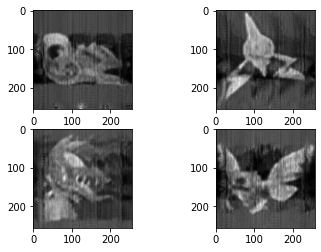

In [ ]:
# Reconstruction Image
plt.figure()
for i in range(1,5):
    plt.subplot(2,2,i)
    pred = model.predict(testdata[i*5].reshape(-1,256,256,1))
    imgpred = (pred*255).reshape(256,256)
    plt.imshow(imgpred,cmap='gray')

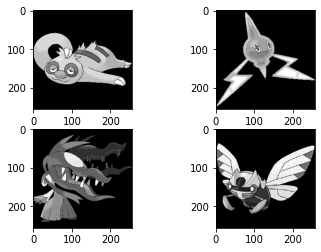

In [ ]:
# Original Image
plt.figure()
for i in range(1,5):
    plt.subplot(2,2,i)
    img = testdata[i*5].reshape(256,256)
    plt.imshow(img,cmap='gray')

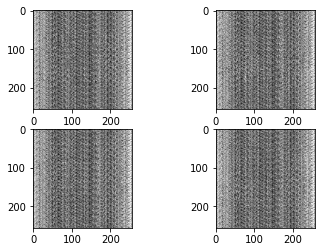

In [ ]:
# Hologram
plt.figure()
for i in range(1,5):
    plt.subplot(2,2,i)
    img = testdata[i*5].reshape(256,256)
    holo= encoder.predict(testdata[5*i].reshape(-1,256,256,1))
    imgholo = (255*(holo+math.pi)/math.pi).astype('uint8')
    plt.imshow(imgholo.reshape(256,256),cmap='gray')

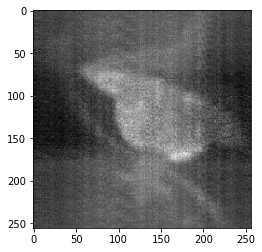

In [ ]:
pred = model.predict(data_val[1].reshape(-1,256,256,1))
imgpred = (pred*255).reshape(256,256,1)
plt.imshow(imgpred,cmap='gray')


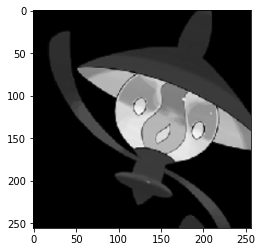

In [ ]:
img = data_val[1].reshape(256,256,1)
plt.imshow(img,cmap='gray')

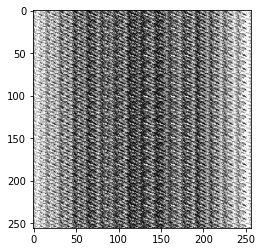

In [ ]:
holo= encoder.predict(data_val[1].reshape(-1,256,256,1))
imgholo = (255*(holo+math.pi)/math.pi/2).astype('uint8')
plt.imshow(imgholo.reshape(256,256),cmap='gray')